In [1]:
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table
from gammapy.data import DataStore
from gammapy.datasets import Datasets, FluxPointsDataset, SpectrumDataset
from gammapy.estimators import FluxPointsEstimator
from gammapy.makers import (
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
)
from gammapy.maps import MapAxis, RegionGeom, WcsGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    LogParabolaSpectralModel,
    SkyModel,
    create_crab_spectral_model,
)
from gammapy.visualization import plot_spectrum_datasets_off_regions
from matplotlib import pyplot as plt
from regions import CircleSkyRegion

In [2]:
# Customize the pyplot figure:
plt.rcParams.update(
    {"figure.figsize": (12, 9), "font.size": 15, "grid.linestyle": "--"}
)

# Load DL3 data

In [3]:
# ================
# === Settings ===
# ================

input_dir = (
    "/home/yoshiki.ohtani/lstmagic/real/CrabNebula/2020_12_15/5.dl2_to_dl3/data/dl3/"
)

obs_ids = [3267, 3268]

# ============
# === Main ===
# ============

data_store = DataStore.from_dir(input_dir)

if obs_ids == "all":
    obs_ids = data_store.obs_table["OBS_ID"].value

observations = data_store.get_observations(obs_ids, required_irf=["aeff", "edisp"])

print(observations)

No HDU found matching: OBS_ID = 3267, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 3267, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 3267, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 3268, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 3268, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 3268, HDU_TYPE = rad_max, HDU_CLASS = None


Observations
Number of observations: 2
Observation

	obs id            : 3267 
 	tstart            : 59198.92
	tstop             : 59198.93
	duration          : 816.02 s
	pointing (icrs)   : 84.0 deg, 22.2 deg

	deadtime fraction : 4.6%
Observation

	obs id            : 3268 
 	tstart            : 59198.93
	tstop             : 59198.94
	duration          : 775.56 s
	pointing (icrs)   : 83.3 deg, 21.8 deg

	deadtime fraction : 4.5%



# Define a target region

In [4]:
# Read one of the input files to get the meta data
file_name = data_store.hdu_table["FILE_NAME"][0]
input_file = f"{input_dir}/{file_name}"

hdu_events = Table.read(input_file, hdu="EVENTS")
hdu_aeff = Table.read(input_file, hdu="EFFECTIVE AREA")

# Get the target position from the meta data
target_position = SkyCoord(
    u.Quantity(hdu_events.meta["RA_OBJ"], u.deg),
    u.Quantity(hdu_events.meta["DEC_OBJ"], u.deg),
    frame="icrs",
)

# Here it assumes that the IRFs are created with a global theta cut
on_region_radius = u.Quantity(hdu_aeff.meta["RAD_MAX"], u.deg)
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

print(on_region)

Region: CircleSkyRegion
center: <SkyCoord (ICRS): (ra, dec) in deg
    (83.63308333, 22.0145)>
radius: 0.2 deg


# Create an exclusion mask

In [5]:
# ================
# === Settings ===
# ================

exclusion_position_name = "RGB J0521+212"
exclusion_region_radius = u.Quantity(0.5, u.deg)

# ============
# === Main ===
# ============

exclusion_position = SkyCoord.from_name(exclusion_position_name, frame="icrs")
exclusion_region = CircleSkyRegion(
    center=exclusion_position, radius=exclusion_region_radius
)

print(exclusion_region)

geom = WcsGeom.create(
    npix=(800, 800), binsz=0.01, skydir=target_position, proj="TAN", frame="icrs"
)

exclusion_mask = ~geom.region_mask([exclusion_region])

Region: CircleSkyRegion
center: <SkyCoord (ICRS): (ra, dec) in deg
    (80.44152391, 21.21429244)>
radius: 0.5 deg


# Run the data reduction chain

In [6]:
# ================
# === Settings ===
# ================

energy_reco_min = 0.1  # unit: [TeV]
energy_reco_max = 3.95  # unit: [TeV]
n_reco_bins_pdec = 5

energy_true_min = 0.01  # unit: [TeV]
energy_true_max = 100  # unit: [TeV]
n_true_bins_pdec = 10

# ============
# === Main ===
# ============

energy_axis = MapAxis.from_energy_bounds(
    energy_reco_min,
    energy_reco_max,
    nbin=n_reco_bins_pdec,
    per_decade=True,
    unit="TeV",
    name="energy",
)

print(f"Reconstructed energy axis:\n{energy_axis.edges}")

energy_axis_true = MapAxis.from_energy_bounds(
    energy_true_min,
    energy_true_max,
    nbin=n_true_bins_pdec,
    per_decade=True,
    unit="TeV",
    name="energy_true",
)

on_geom = RegionGeom.create(region=on_region, axes=[energy_axis])
dataset_empty = SpectrumDataset.create(geom=on_geom, energy_axis_true=energy_axis_true)

Reconstructed energy axis:
[0.1        0.15833417 0.25069708 0.39693913 0.62849025 0.9951148
 1.57560671 2.49472373 3.95      ] TeV


In [7]:
# Define a SpectrumDatasetMaker, assuming tha the input data is the
# point-like IRFs. Even if the "use_region_center" is set to True,
# there will be the following warnings when using gammapy v0.19:

# "MapMaker: use_region_center=False should not be used with
# point-like IRF. Results are likely inaccurate"

# It can be safely ignored since we set the argument to True,
# This issue is already fixed in the next version of gammapy.

dataset_maker = SpectrumDatasetMaker(
    containment_correction=False,
    selection=["counts", "exposure", "edisp"],
    use_region_center=True,
)

print(dataset_maker)

bkg_maker = ReflectedRegionsBackgroundMaker(
    exclusion_mask=exclusion_mask,
    min_distance=u.Quantity(100, u.deg),
    max_region_number=1,
)

safe_mask_maker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

SpectrumDatasetMaker
--------------------

  selection               : {'counts', 'exposure', 'edisp'}
  containment_correction  : False
  background_oversampling : None
  use_region_center       : True



In [8]:
datasets = Datasets()

for obs_id, observation in zip(obs_ids, observations):

    dataset = dataset_maker.run(dataset_empty.copy(name=str(obs_id)), observation)
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_maker.run(dataset_on_off, observation)

    datasets.append(dataset_on_off)

print(datasets)

MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.
MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


Datasets
--------

Dataset 0: 

  Type       : SpectrumDatasetOnOff
  Name       : 3267
  Instrument : CTA-N
  Models     : 

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : 3268
  Instrument : CTA-N
  Models     : 




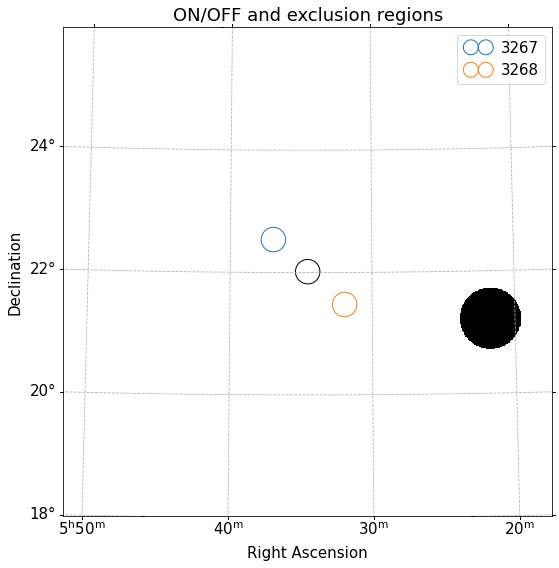

In [9]:
plt.figure()

# Plot the ON, OFF and exclusion regions
ax = exclusion_mask.plot()
on_region.to_pixel(ax.wcs).plot(ax=ax, edgecolor="black")

plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets)

ax.set_title("ON/OFF and exclusion regions")
ax.grid()

# Check source statistics

In [10]:
info_table = datasets.info_table(cumulative=True)

In [11]:
info_table

name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,343,83.0,260.0,13.053340663050166,213.0,213.0,nan,973.3811645507812,231618496.0,778.2106890995926,816.0225415229797,0.4407546758280316,0.10665492155605429,0.3340997542719773,8,7,wstat,185.37371322307249,83,7.0,7.0,1.0
stacked,625,149.0,476.0,17.740466074264962,387.0,387.0,nan,1899.640380859375,452024192.0,1518.7476998131426,1591.5791301727295,0.4115232570076624,0.09810714447062671,0.31341611253703566,8,7,wstat,344.6933597992758,149,7.0,7.0,1.0


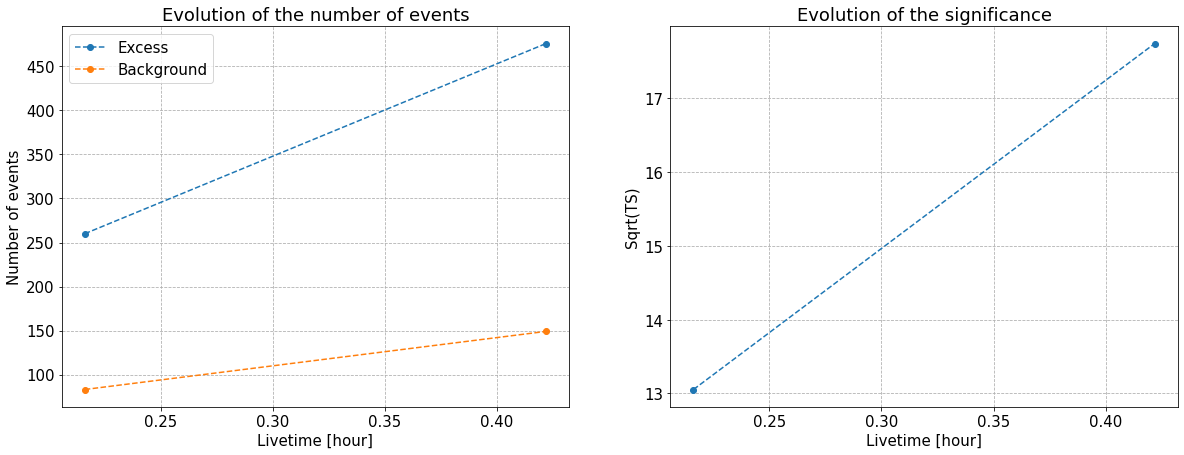

In [12]:
plt.figure(figsize=(20, 7))
grid = (1, 2)

# Plot the number of events along the livetime
plt.subplot2grid(grid, (0, 0))
plt.title("Evolution of the number of events")
plt.xlabel("Livetime [hour]")
plt.ylabel("Number of events")

plt.plot(
    info_table["livetime"].to("h"),
    info_table["excess"],
    marker="o",
    linestyle="--",
    label="Excess",
)

plt.plot(
    info_table["livetime"].to("h"),
    info_table["background"],
    marker="o",
    linestyle="--",
    label="Background",
)

plt.grid()
plt.legend()

# Plot the significance along the livetime
plt.subplot2grid(grid, (0, 1))
plt.title("Evolution of the significance")
plt.xlabel("Livetime [hour]")
plt.ylabel("Sqrt(TS)")

plt.plot(
    info_table["livetime"].to("h"), info_table["sqrt_ts"], marker="o", linestyle="--"
)

plt.grid()

# Fit a spectrum

In [13]:
# ================
# === Settings ===
# ================

model_function = LogParabolaSpectralModel

parameters = {
    "amplitude": u.Quantity(5e-12, u.Unit("cm-2 s-1 TeV-1")),
    "alpha": u.Quantity(2),
    "beta": u.Quantity(0.1),
    "reference": u.Quantity(1, u.TeV),
}

# ============
# === Main ===
# ============

spectral_model = model_function(**parameters)
model = SkyModel(spectral_model=spectral_model, name="target_source")

stacked_dataset = datasets.stack_reduce()
stacked_dataset.models = model

fit = Fit()
results = fit.run(datasets=stacked_dataset)

print(results)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 158
	total stat : 0.35

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 158
	total stat : 0.35




In [14]:
stacked_dataset.models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,link
str13,str8,str9,float64,str14,float64,float64,float64,bool,str1
target_source,spectral,amplitude,2.8167e-11,cm-2 s-1 TeV-1,2.697e-12,nan,nan,False,
target_source,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,
target_source,spectral,alpha,2.8175e+00,,1.560e-01,nan,nan,False,
target_source,spectral,beta,2.1872e-01,,9.721e-02,nan,nan,False,


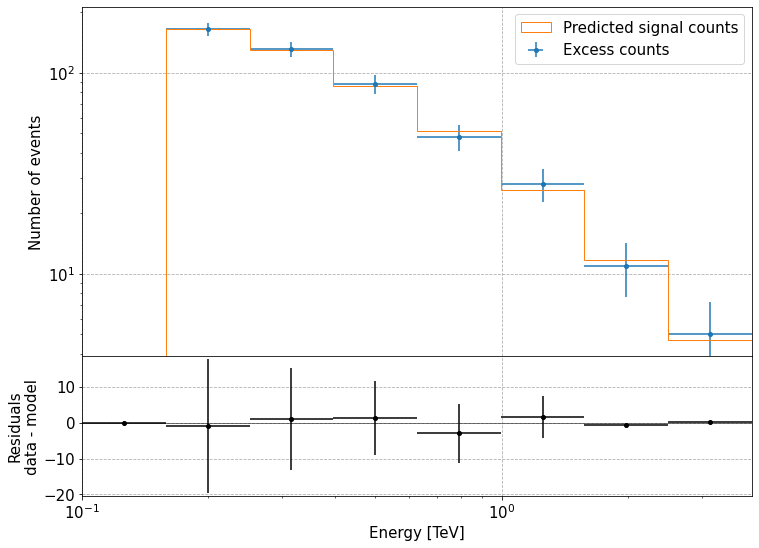

In [15]:
plt.figure()

ax_spectrum, ax_residuals = stacked_dataset.plot_fit()

ax_spectrum.set_ylabel("Number of events")
ax_spectrum.grid()

plt.setp(ax_spectrum.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=0)

ax_residuals.grid()

# Calculate the flux points

In [16]:
fpe = FluxPointsEstimator(
    energy_edges=energy_axis.edges, source="target_source", selection_optional="all"
)

flux_points = fpe.run(datasets=stacked_dataset)
flux_points_dataset = FluxPointsDataset(data=flux_points, models=stacked_dataset.models)

In [17]:
flux_points.to_table(sed_type="e2dnde", formatted=True)

e_ref,e_min,e_max,e2dnde,e2dnde_err,e2dnde_errp,e2dnde_errn,e2dnde_ul,ts,sqrt_ts,npred [1],npred_excess [1],stat,is_ul,counts [1],success,norm_scan [11],stat_scan [11]
TeV,TeV,TeV,TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,bool,float64,bool,float64,float64
0.126,0.100,0.158,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.199,0.158,0.251,5.917e-11,6.660e-12,6.721e-12,6.607e-12,7.275e-11,82.236,9.068,254.99847561949383,164.99794,0.000,False,255.0,True,0.200 .. 5.000,53.061 .. 645.398
0.315,0.251,0.397,5.459e-11,5.967e-12,6.060e-12,5.883e-12,6.691e-11,90.616,9.519,167.99595387929426,130.99506,0.000,False,168.0,True,0.200 .. 5.000,59.623 .. 548.608
0.499,0.397,0.628,4.547e-11,5.320e-12,5.468e-12,5.183e-12,5.672e-11,85.342,9.238,96.98457039043416,87.98314,0.000,False,97.0,True,0.200 .. 5.000,57.680 .. 391.530
0.791,0.628,0.995,3.153e-11,5.416e-12,5.581e-12,5.274e-12,4.305e-11,37.478,6.122,58.003725332084166,48.004368,0.000,False,58.0,True,0.200 .. 5.000,23.887 .. 236.272
1.252,0.995,1.576,2.471e-11,5.146e-12,5.402e-12,4.922e-12,3.607e-11,26.840,5.181,30.997371677587914,27.997118,0.000,False,31.0,True,0.200 .. 5.000,18.504 .. 114.518
1.983,1.576,2.495,1.364e-11,4.113e-12,4.536e-12,3.710e-12,2.360e-11,15.249,3.905,10.999942561815523,10.999943,0.000,False,11.0,True,0.200 .. 5.000,10.563 .. 58.367
3.139,2.495,3.950,8.897e-12,3.979e-12,4.593e-12,3.409e-12,1.938e-11,6.931,2.633,4.99996269454868,4.999963,0.000,False,5.0,True,0.200 .. 5.000,5.065 .. 21.264


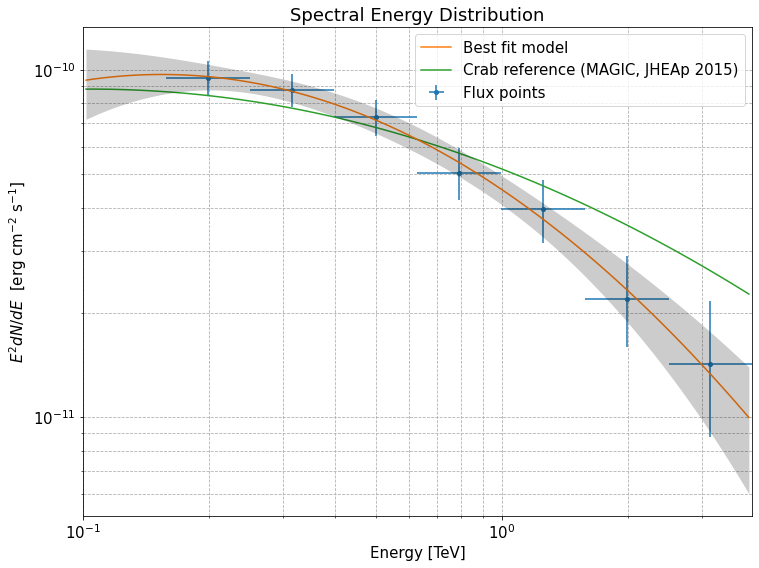

In [18]:
plt.figure()

plot_kwargs = {"sed_type": "e2dnde", "yunits": u.Unit("erg cm-2 s-1")}

# Plot the computed flux points:
ax = flux_points_dataset.plot_spectrum(kwargs_model=plot_kwargs)

# Draw the Crab reference spectrum:
create_crab_spectral_model("magic_lp").plot(
    ax=ax,
    energy_bounds=energy_axis.edges[[0, -1]],
    label="Crab reference (MAGIC, JHEAp 2015)",
    **plot_kwargs,
)

ax.set_title("Spectral Energy Distribution")
ax.set_ylabel("$E^2dN/dE$  [erg cm$^{-2}$ s$^{-1}$]")
ax.grid(which="both")
ax.legend()